In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
cancer = load_breast_cancer()

x = cancer.data
y = cancer.target

# train / test 데이터 분리
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [2]:
x_train_all.shape

(455, 30)

In [3]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test) # loss와 같은 매개 변수는 사용자가 선택하기 때문에 하이퍼 파라미터에 해당한다.

0.8333333333333334

In [4]:
sgd = SGDClassifier(loss="hinge", random_state=42) # hinge로 변경하면 선형 SVM 문제를 해결하는 모델로 변경된다.
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.9385964912280702

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

print(len(x_train), len(x_val))

364 91


In [6]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss="log", random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_test, y_test) # 검증 데이터를 훈련 데이터에서 한 번 더 분류하면서 데이터가 줄어들어 정확도가 감소하는 현상 발생

0.6929824561403509

In [7]:
# 데이터 스케일 비교하기 (데이터의 형태가 균일하지 않을 경우, 제대로 된 결과를 얻지 못할 가능성이 높음)

print(cancer.feature_names[[2,3]])

['mean perimeter' 'mean area']


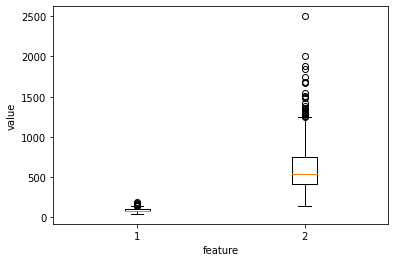

In [8]:
plt.boxplot(x_train[:, 2:4])
plt.xlabel("feature")
plt.ylabel("value")
plt.show()

In [9]:
import numpy as np
class DoItSigleLayerLogistic:
    def __init__(self, learning_rate=0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = [] # new
        self.lr = learning_rate # new
        
    def forward_propagation(self, x):
        z = np.sum(self.w * x) + self.b
        return z
    
    def backward_propagation(self,x, err):
        dw = x * err
        db = 1 * err
        return dw, db
    
    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs = 100):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        
        for i in range(epochs):
            
            loss = 0
            idx = np.random.permutation(np.arange(len(x))) # 인덱스 셔플
            
            for j in idx:
                z = self.forward_propagation(x[j])
                a = self.activation(z)
                
                err = - (y[j] - a)
                dw, db = self.backward_propagation(x[j], err)
                self.w -= dw * self.lr
                self.b -= db
                
                self.w_history.append(self.w.copy())
                
                a = np.clip(a, 1e-10, 1-1e-10) # 안전한 로그 계산을 위한 클리핑 후 손실 누적 작업?
                
                loss += -(y[j] * np.log(a) + (1-y[j]) * np.log(1-a))
                
            self.losses.append(loss/len(y))
        
    def predict(self, x):
        z = [self.forward_propagation(x_i) for x_i in x]
        return np.array(z) > 0 #스텝 함수 적용?
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [10]:
layer1 = DoItSigleLayerLogistic()

layer1.fit(x_train, y_train)

layer1.score(x_val, y_val)

0.9120879120879121

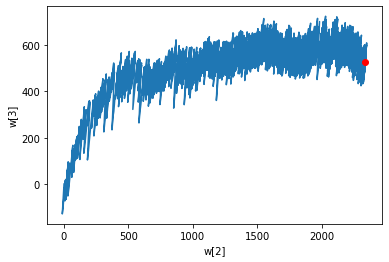

In [11]:
w2 = []
w3 = []

for w in layer1.w_history:
    w2.append(w[2])
    w3.append(w[3])
    
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], "ro")
plt.xlabel("w[2]")
plt.ylabel("w[3]")
plt.show() # w2는 값이 0부터 서서히 최적값에 수렴하는데 w3는 축을 따라 요동치고 있음. 스케일 조정이 안되어 있기 때문임.

In [12]:
# 이러한 특성들의 스케일 조정을 위해 표준화를 도입함
# 특성값에서 평균을 빼고, 표준 편차로 나누는 방식
# 표준화를 적용하면 평균이 0이고 분산이 1인 특성이 생성됨.

train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)

x_train_scaled = (x_train - train_mean) / train_std

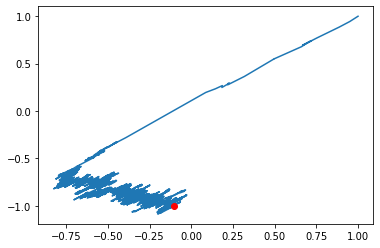

In [13]:
layer2 = DoItSigleLayerLogistic()

layer2.fit(x_train_scaled, y_train)

w2 = []
w3 = []

for w in layer2.w_history:
    w2.append(w[2])
    w3.append(w[3])
    
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], "ro") # 두 특성의 스케일이 어느 정도 맞춰지면서 최적값에 빠르게 접근하는 것을 볼 수 있음.

In [14]:
layer2.score(x_val, y_val) # 검증세트의 스케일 조정이 안되어 결과가 안좋음

0.37362637362637363

In [15]:
# 검증 데이터 표준화 (잘못된 표준화 예시) -> 교묘한 함정이 숨어져 있음

val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)

x_val_scaled = (x_val - val_mean) / val_std

In [16]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

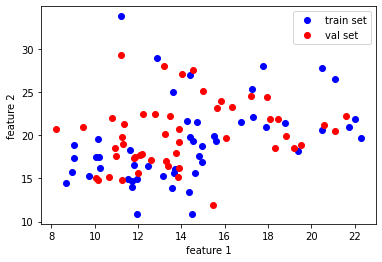

In [17]:
plt.plot(x_train[:50, 0], x_train[:50, 1], "bo")
plt.plot(x_val[:50, 0], x_val[:50, 1], "ro")

plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["train set", "val set"])
plt.show()

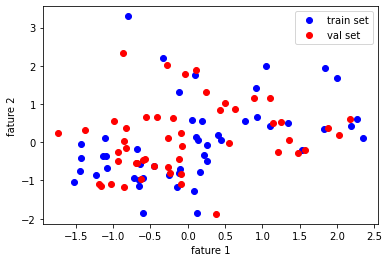

In [18]:
plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], "bo")
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], "ro")

plt.xlabel("fature 1")
plt.ylabel("fature 2")
plt.legend(["train set", "val set"])
plt.show() # 미세하게 훈련 데이터와 검증 데이터가 각각 다른 비율로 변환되어 있음. 훈련 & 검증 데이터를 같은 비율로 전처리해야함.

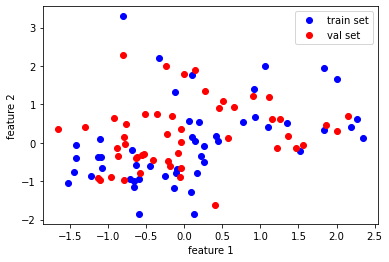

In [19]:
x_val_scaled = (x_val - train_mean) / train_std

plt.plot(x_train_scaled[:50, 0], x_train_scaled[:50, 1], "bo")
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50, 1], "ro")

plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(["train set", "val set"])
plt.show()

In [20]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

In [21]:
import numpy as np
class DoItSigleLayerLogistic2:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.w_history = [] # new
        self.lr = learning_rate # new
        self.val_losses = []
        self.l1 = l1
        self.l2 = l2
        
    def forward_propagation(self, x):
        z = np.sum(self.w * x) + self.b
        return z
    
    def backward_propagation(self,x, err):
        dw = x * err
        db = 1 * err
        return dw, db
    
    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
    
    def fit(self, x, y, epochs = 100, x_val=None, y_val=None):
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        
        for i in range(epochs):
            
            loss = 0
            idx = np.random.permutation(np.arange(len(x))) # 인덱스 셔플
            
            for j in idx:
                z = self.forward_propagation(x[j])
                a = self.activation(z)
                
                err = - (y[j] - a)
                dw, db = self.backward_propagation(x[j], err)
                
                dw += self.l1 * np.sign(self.w) + self.l2 * self.w
                
                self.w -= dw * self.lr
                self.b -= db
                
                self.w_history.append(self.w.copy())
                
                a = np.clip(a, 1e-10, 1-1e-10) # 안전한 로그 계산을 위한 클리핑 후 손실 누적 작업?
                
                loss += -(y[j] * np.log(a) + (1-y[j]) * np.log(1-a))
                
            self.losses.append(loss/len(y) + self.reg_loss())
            
            self.update_val_loss(x_val, y_val)
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
            
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        
        for i in range(len(x_val)):
            z = self.forward_propagation(x_val[i])
            a = self.activation(z)
            z = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i] * np.log(a) + (1-y_val[i]) * np.log(1-a))
            
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())
        
    def predict(self, x):
        z = [self.forward_propagation(x_i) for x_i in x]
        return np.array(z) > 0 #스텝 함수 적용?
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [22]:
# 과대적합 (overfitting) -> 분산이 크다(high variance)
# 과소적합 (underfitting) -> 편향이 크다 (high bias)

# 둘의 관계는 기본적으로 trade-off임

layer3 = DoItSigleLayerLogistic2()

layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

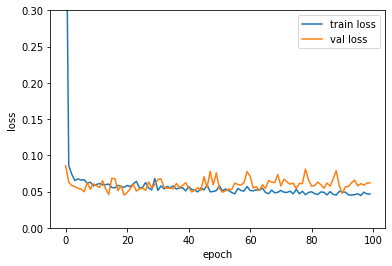

In [23]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train loss", "val loss"])
plt.show() # 20 에폭 이후 검증 세트의 손실 값이 훈련세트보다 높아지는 것을 볼 수 있음

In [24]:
layer4 = DoItSigleLayerLogistic()

layer4.fit(x_train_scaled, y_train, epochs=20)

layer4.score(x_val_scaled, y_val)

0.978021978021978

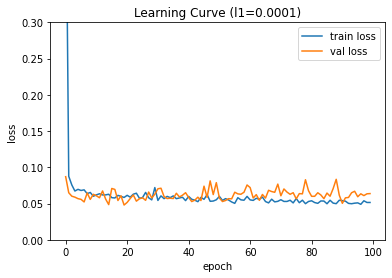

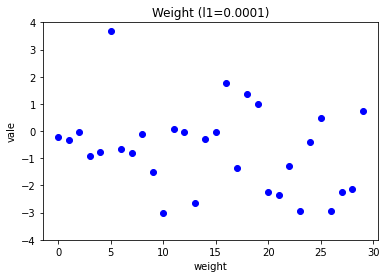

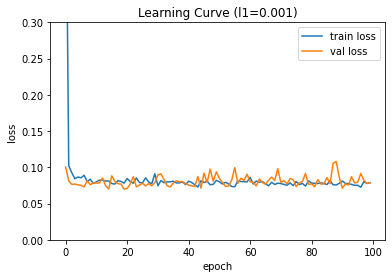

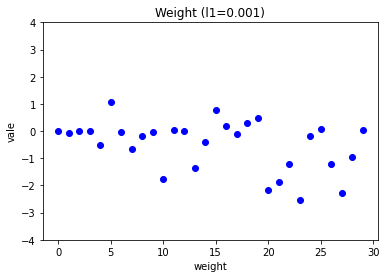

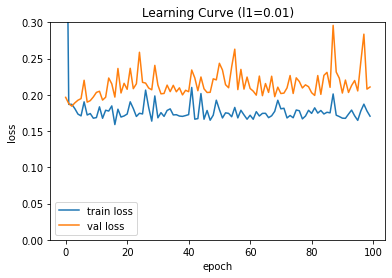

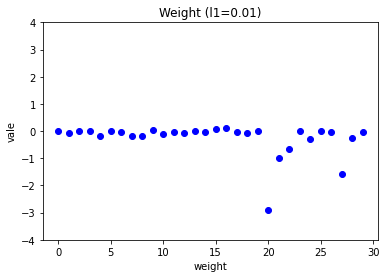

In [25]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = DoItSigleLayerLogistic2(l1=l1)
    
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    
    plt.title("Learning Curve (l1={})".format(l1))
    plt.ylabel("loss")
    plt.xlabel("epoch")
    
    plt.legend(["train loss", "val loss"])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, "bo")
    
    plt.title("Weight (l1={})".format(l1))
    plt.ylabel("vale")
    plt.xlabel("weight")
    
    plt.ylim(-4, 4)
    plt.show()

In [27]:
layer5 = DoItSigleLayerLogistic(learning_rate=0.001)

layer5.fit(x_train_scaled, y_train, epochs=20)

layer5.score(x_val_scaled, y_val)

0.9340659340659341

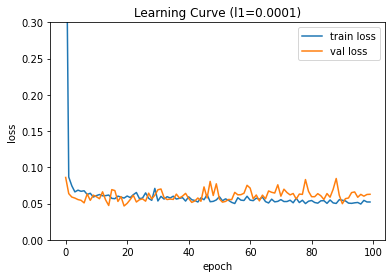

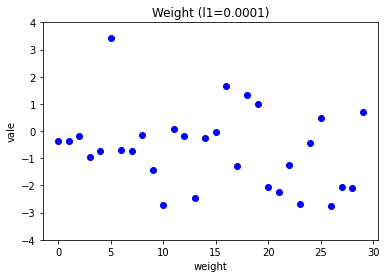

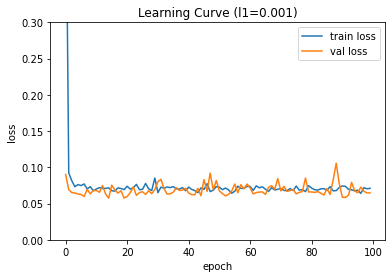

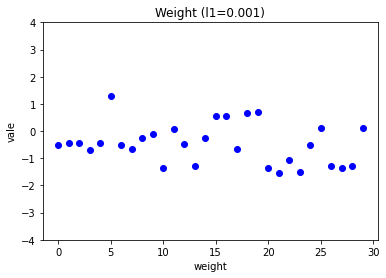

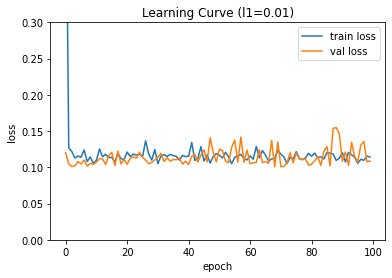

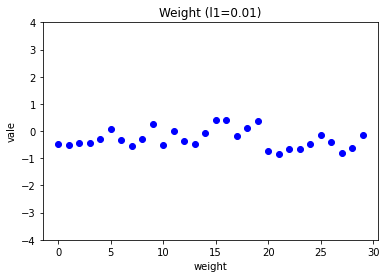

In [28]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = DoItSigleLayerLogistic2(l2=l2)
    
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    
    plt.title("Learning Curve (l1={})".format(l2))
    plt.ylabel("loss")
    plt.xlabel("epoch")
    
    plt.legend(["train loss", "val loss"])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, "bo")
    
    plt.title("Weight (l1={})".format(l2))
    plt.ylabel("vale")
    plt.xlabel("weight")
    
    plt.ylim(-4, 4)
    plt.show()

In [29]:
layer6 = DoItSigleLayerLogistic2(l2=0.01)

layer6.fit(x_train_scaled, y_train, epochs=50)

layer6.score(x_val_scaled, y_val)

0.978021978021978

In [30]:
np.sum(layer6.predict(x_val_scaled) == y_val)

89

In [32]:
sgd = SGDClassifier(loss="log", penalty="l2", alpha=0.001, random_state=42) # 사이킷런은 l1, l2 규제 모두 지원함
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978

In [33]:
# 최종 : k-fold 교차 검증 점수를 계산하기 위한 리스트 생성
validation_score = []

In [35]:
# k-fold 구현 (사이킷런 없이)

k = 10

bins = len(x_train) // k

for i in range(k):
    start = i * bins
    end = (i+1) * bins
    
    val_fold = x_train_all[start:end]
    
    val_target =  y_train_all[start:end]
    
    train_index = list(range(0, start)) + list(range(end, len(x_train)))
    
    train_fold = x_train_all[train_index]
    
    train_target = y_train_all[train_index]
    
    train_mean = np.mean(train_fold, axis=0)
    
    train_std = np.std(train_fold, axis=0)
    
    train_fold_scaled = (train_fold - train_mean) / train_std
    
    val_fold_scaled = (val_fold - train_mean) / train_std
    
    lyr = DoItSigleLayerLogistic2(l2=0.01)
    
    lyr.fit(train_fold_scaled, train_target, epochs=50)

    score = lyr.score(val_fold_scaled, val_target)
    validation_score.append(score)
print(np.mean(validation_score))

0.9583333333333333


In [36]:
from sklearn.model_selection import cross_validate

sgd = SGDClassifier(loss="log", penalty="l2", alpha=0.001, random_state=42)

scores = cross_validate(sgd, x_train_all, y_train_all, cv=10)

print(np.mean(scores["test_score"])) # 전처리가 안된 데이터를 사용했기 때문에 상대적으로 점수가 낮다.

0.850096618357488


In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipe = make_pipeline(StandardScaler(), sgd)

scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores["test_score"]))

0.9694202898550724
